![official logo](../logo.png "Filmowledge")

By CARASCO Mathias & PERRIN Nicolas

## Installs + Imports

In [ ]:
# Run only if you need to run the "Enrich data" part
!py -m pip install --upgrade pip
!py -m pip install -q git+https://github.com/boudinfl/pke.git
!py -m spacy download en_core_web_sm
!py -m pip install rdflib
!py -m pip install oxrdflib

In [1]:
from tqdm import tqdm
from time import time, sleep
import requests
import json
import re

In [2]:
import pke

In [3]:
from rdflib import Graph, ConjunctiveGraph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD

In [329]:
from ipywidgets import interact

## Utils
These functions need to be run because they may be used in different sections of the notebook.

In [305]:
def format_str(string: str, **kwargs):
    for key, value in kwargs.items():
        string = string.replace('{{ '+key+' }}', str(value))
    return string

def to_camel_case(string):
    string = string.replace('-', ' ')
    words = string.split(" ")
    camel_case = ""
    for word in words[:]:
        camel_case += word.capitalize()
    return camel_case

def wrap_text(text: str, wrap_after):
    last_space = 0
    last_space_n = 0
    new_text = ""
    for i in range(len(text)):
        if text[i] in ('-',' ', ':'):
            last_space = i
            last_space_n = len(new_text)
        new_text += text[i]
        if i%wrap_after == 0 and i:
            new_text = new_text[:last_space_n]+'\n'+new_text[last_space_n+1:]
    return new_text

## Gathering data from API

In [ ]:
API_KEY = "d6103800bdd84d0eedb89128368992ff"
LANGUAGE = "en-US"
BASE_URL = "https://api.themoviedb.org/3/discover/movie?"

MAX_PAGES = 500

def set_params(url: str, **kwargs):
    param_str = ""
    for key, value in kwargs.items():
        param_str += key+'='+str(value)+'&'
    return url+param_str[:-1]

pages_json = []

for page in tqdm(range(1, MAX_PAGES)):
    url = set_params(BASE_URL,
                     api_key=API_KEY,
                     language=LANGUAGE,
                     sort_by='popularity.desc',
                     include_adult='false',
                     include_video='false',
                     with_watch_monetization_types='flatrate',
                     page=page)
    r = requests.get(url)
    json_obj = r.json()
    pages_json.append(json_obj)
    file = open(f"api_dumps/page_{str(page).zfill(5)}.json", "w")
    file.write(json.dumps(json_obj, indent=4))
    sleep(0.1)

In [ ]:
# Concatenation of individual movies to obtain a full list of movies
movies = []
for page in pages_json:
    movies.extend(page['results'])

In [ ]:
# Saving data into a json file
f = open("movies.json", "w")
f.write(json.dumps(movies, indent=4))
f.close()

In [ ]:
# Loading data from file saved in a previous session
movies = []
f = open("movies.json", "r")
movies = json.loads(f.read())
f.close()

In [ ]:
list(map(lambda x: x['original_title'], movies))

In [ ]:
movies[0]

## Enrich data
The goal is now to enrich data by linking topics to movies. This will be achieved by using a Topic Modeling method to extract topics from the title of the movie and its overview (summary).

In [ ]:
# initialize keyphrase extraction model, here TopicRank
extractor = pke.unsupervised.TopicRank()

def extract_keyphrases(extractor, text, n=20):
    # load the content of the document, here document is expected to be a simple 
    # test string and preprocessing is carried out using spacy
    extractor.load_document(input=text, language='en')

    # keyphrase candidate selection, in the case of TopicRank: sequences of nouns
    # and adjectives (i.e. `(Noun|Adj)*`)
    extractor.candidate_selection()

    # candidate weighting, in the case of TopicRank: using a random walk algorithm
    extractor.candidate_weighting()

    # N-best selection, keyphrases contains the 10 highest scored candidates as
    # (keyphrase, score) tuples
    keyphrases = extractor.get_n_best(n=n)

    return keyphrases

extract_keyphrases(extractor, movies[1]['original_title']+'. '+movies[1]['overview'])

In [ ]:
def cleanup_topic(topic):
    return re.sub(r'[^a-zA-Z0-9 ]', '', topic.replace('-', ' '))

cleanup_topic("epic-journey²*!")

In [ ]:
# We do the operation on each movie, so we have associated topics for each of them.

for movie in tqdm(movies):
    list_of_topics = []
    for topic, _ in extract_keyphrases(extractor, movie['original_title']+'. '+movie['overview']):
        cleaned_topic = cleanup_topic(topic)
        if cleaned_topic.replace(' ', ''):
            list_of_topics.append(cleaned_topic)
    movie["topics"] = list_of_topics

In [ ]:
# Saving the enriched data in the json format.

f = open("movies_enriched.json", "w")
f.write(json.dumps(movies, indent=4))
f.close()

In [ ]:
# Loading enriched data from previous session.

movies = []
f = open("movies_enriched.json", "r")
movies = json.loads(f.read())
f.close()

In [ ]:
movies[1]

In [ ]:
# We show an overview of the different topics that have been collected and the number of movies each topic is associated with.

topics = {}
for movie in tqdm(movies):
    for topic in movie["topics"]:
        if topic in topics:
            topics[topic] += 1
        else:
            topics[topic] = 1

all_topics = list(topics.keys())
topics

In [ ]:
# We also define a function to play around and see with which movies one topic is associated with.
# Ultimately, this is just a POC, but we will later use RDF for our final application.

def search_keyword(keyword):
    if keyword in topics:
        print(f'{str(topics[keyword])} results found for "{keyword}"')
        print("------------------------------------------------------")
        for movie in movies:
            if keyword in movie["topics"]:
                print(movie['title'])

In [ ]:
search_keyword('beasts')

In [ ]:
all_topics = []
for topic in topics:
    t_ = re.sub(r'[^a-zA-Z0-9 ]', '', topic)
    if t_.replace(' ', ''):
        all_topics.append(t_)

with open("all_topics.txt", "w") as f:
    f.write('\n'.join(all_topics))
all_topics_set = set(all_topics)
all_topics

In [ ]:
def find_similar_topics_2(topic, all_topics_):
    similar_topics = []
    for topic_tested in all_topics_:
        if topic_tested in (topic+'s', topic+topic[-1]+'y'):
            similar_topics.append(topic_tested)
    return similar_topics

def find_similar_topics(topic, all_topics_): # Much much faster
    similar_topics = []
    for tested_topic in (topic+'s', topic+topic[-1]+'y'):
        if tested_topic in all_topics_:
            similar_topics.append(tested_topic)
    return similar_topics

k = 'sun'
#search_keyword(k)
find_similar_topics(k, all_topics_set)

## Lifting Topics to RDF
We will now lift our data to RDF, precisely our Topics, so we will later be able to link movies to each others from those topics. For that, we have to create a vocabulary that will allow this interoperability.

In [ ]:
ttl_header = """@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix : <http://myvocab.org/> .

:Topic a skos:Concept ;
    skos:prefLabel "Topic"@en ;
    rdfs:label "Topic"@en ;
    skos:definition "A subject or area of interest or discussion."@en .

:similarTo a owl:SymmetricProperty ;
    rdfs:label "similar to"@en ;
    rdfs:comment "A word that is similar to another in terms of meaning and construction."@en ;
    rdfs:domain :Topic ;
    rdfs:range :Topic .
    
:relevance a owl:DatatypeProperty ;
    rdfs:label "relevance"@en ;
    rdfs:comment "relevance of a topic based on its specificity. The more semantically complex the more relevant."@en ;
    rdfs:domain :Topic ;
    rdfs:range xsd:integer .
"""


In [4]:
def topic_to_rdf(topic, related_topics):
    text = ''':{{ ressource_name }} a :Topic ;
    skos:prefLabel "{{ topic }}"@en ;
    :relevance {{ relevance }}'''
    rdf = format_str(text,
                     ressource_name=to_camel_case(topic),
                     topic=topic,
                     relevance=len(topic.split(' ')))
    if related_topics:
        rdf += ' ;\n    :similarTo '+', '.join(map(lambda x: ':'+to_camel_case(x), related_topics))
    return rdf+" . \n\n"

print(topic_to_rdf("fun", ["funny"]))

:Fun a :Topic ;
    skos:prefLabel "fun"@en ;
    :relevance 1 ;
    :similarTo :Funny . 




In [ ]:
ttl_body = ttl_header
for topic in tqdm(all_topics_set):
    ttl_body += topic_to_rdf(topic, find_similar_topics(topic, all_topics_set))
    
# Saving the ttl file.
f = open("topics.ttl", "w", encoding="utf-8")
f.write(ttl_body)
f.close()

In [ ]:
# Saving the ttl file.
f = open("topics.ttl", "w", encoding="utf-8")
f.write(ttl_body)
f.close()

## Interact with the system
Now, let us play around using our ontology to get recommended movies.

In [9]:
def categorize_input(input_string, n_groups):
    input_string = re.sub(r'[^a-zA-Z0-9 ]', '', input_string.replace('-', ' ').lower())
    words = input_string.split(' ')
    clusters = []
    for i in range(n_groups):
        k = 0
        while k+i < len(words):
            clusters.append(' '.join(words[k:min(k+i+1, len(words))]))
            k = k+1
    return clusters
    
print(categorize_input("hello today the sky is blue.", 4))

['hello', 'today', 'the', 'sky', 'is', 'blue', 'hello today', 'today the', 'the sky', 'sky is', 'is blue', 'hello today the', 'today the sky', 'the sky is', 'sky is blue', 'hello today the sky', 'today the sky is', 'the sky is blue']


In [294]:
g = Graph(store='SimpleMemory')

graphs_paths = ("../ontology/schema/MergedSchemas.ttl",
                "topics.ttl",
                "../Filmowledge/DataLifting/output_bis.ttl")
# On charge les schémas
for graph_path in tqdm(graphs_paths):
    g.parse(graph_path, format="turtle")

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.27s/it]


In [295]:
def sparql_request_valid_topics(graph, topics):
    res = []
    query = '''
        select ?topic ?relevance where {
           ?topic skos:prefLabel ?label .
           ?topic :relevance ?relevance
           FILTER (?label IN ({{ topic_labels }}))
        }
        '''
    topics_str = '"'+'"@en, "'.join(topics)+'"@en'
    query = format_str(query,
                      topic_labels=topics_str)
    t_ = graph.query(query)
    for _ in t_:
        res.append(_.topic)
    return res

def sparql_request_from_topics(graph, topics, limit=50):
    '''
    Requests the graph to retrieve the movies from the given topics.
    Topics has to be a list : names = ["Action", "Romantic", "Thriller", ...]
    '''
    topics = [':'+topic.split('/')[-1]+', ' for topic in topics] # Add ':' to match the format of topics in the graph
    topics_str = ' '.join(topics)[:-2]
    sparql_query = """
    PREFIX movie: <http://example.com/movie#> 
    PREFIX : <http://myvocab.org/> 

    SELECT ?title ?poster_path (SUM(?relevanceBis) AS ?score)
    WHERE {
        ?movie movie:Title ?title.
        ?movie movie:PosterPath ?poster_path.
        ?movie movie:hasTopic ?topic.
        ?movie movie:Popularity ?popularity.
        ?topic :relevance ?relevance.
        BIND(?relevance*?relevance AS ?relevanceBis).
        FILTER  (?topic IN ({{ topics }})
                   || ?similarTopic IN ({{ topics }}))
    }
    GROUP BY ?movie
    ORDER BY DESC(?score)
    {{ limit_clause }}
    """
    sparql_query = format_str(sparql_query,
                              topics=topics_str,
                              limit_clause=f"LIMIT {str(limit)}")
    qres = g.query(sparql_query)
    return qres
        
#Appel d'exemple, pour récupérer les films parlant de Criminals
#sparql_request_from_topics(g, ["Criminals"])

In [363]:
LIMIT = 30 # movies to display

In [339]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [347]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

n = 2
m = 3

cte = 7
cte2 = 0.2
cte3 = 1.6
my_dpi = 100
img_w = 200
img_h = 300 

def choose_renderer(Output_Type): 
    return Output_Type 

def show_visual(qres):
    # Create a figure with n*m subplots
    n = len(qres)//m+len(qres)%m
    if n == 0:
        print("Unfortunately, there is movie matching your input description... Please give more context.")
        return
    fig, axs = plt.subplots(n, m, figsize=(m*cte, n*cte))

    # Iterate through each subplot and create a light grey box with round corners and a black inner box
    i=0
    for ax in axs.flat:
        # Hide the x and y axis
        ax.axis('off')
        if i == len(qres):
            continue
        # Create a Rectangle patch
        rect = FancyBboxPatch((-img_w*cte2, -img_h*cte2*cte3), 0, 10, 
                                  boxstyle="round,pad=0,rounding_size=30", fc='lightgrey', ec='lightgrey', 
                                  lw=0)
        # Create a Rectangle patch
        rect2 = patches.Rectangle((0.2, 0.2), 0.6, 0.6,
                                  linewidth=1,
                                  edgecolor='black',
                                  facecolor='black')

        # Add the patches to the Axes
        ax.add_patch(rect)
        ax.add_patch(rect2)
        # Set the size of each light gray box
        ax.set_xlim(-img_w*cte2, img_w*(1+cte2))
        ax.set_ylim(-img_h*cte2*cte3, img_h*(1+2*cte2)-img_h*cte2*cte3)
        # Set the size of each black box
        rect.set_width(img_w*(1+2*cte2))
        rect.set_height(img_h*(1+2*cte2))
        rect2.set_width(img_w)
        rect2.set_height(img_h)

        ax.text(img_w/2, -img_h*cte2/cte3, wrap_text(qres[i].title, 16),
                horizontalalignment='center',
                verticalalignment='center',
                fontweight='bold',
                fontsize=15,
                wrap=True)
        try:
            img_url = "https://image.tmdb.org/t/p/w200/"+qres[i].poster_path
            with urllib.request.urlopen(img_url) as url:
                s = url.read()
            img = PIL.Image.open(BytesIO(s))
            ax.imshow(img, extent=(0,200,0,300), zorder=2)
        except:
            pass
        i+=1

    # Show the figure
    plt.show()

def show_textual(qres):
    for row in qres:
        print(f'"{row.title}" has a matching score of {row.score}')

In [360]:
render_choice = 'textual'

In [364]:
render_choice = 'visual'

--------------------------------------------------------------
----------------------- FILMOWLEDGE CLI ----------------------
--------------------------------------------------------------
Please describe what kind of movies you are looking for today:
romantic chaotic wedding

--------------------------------------------------------------
We are identifying your interests...
Looking for interesting movies...
Loading the results...


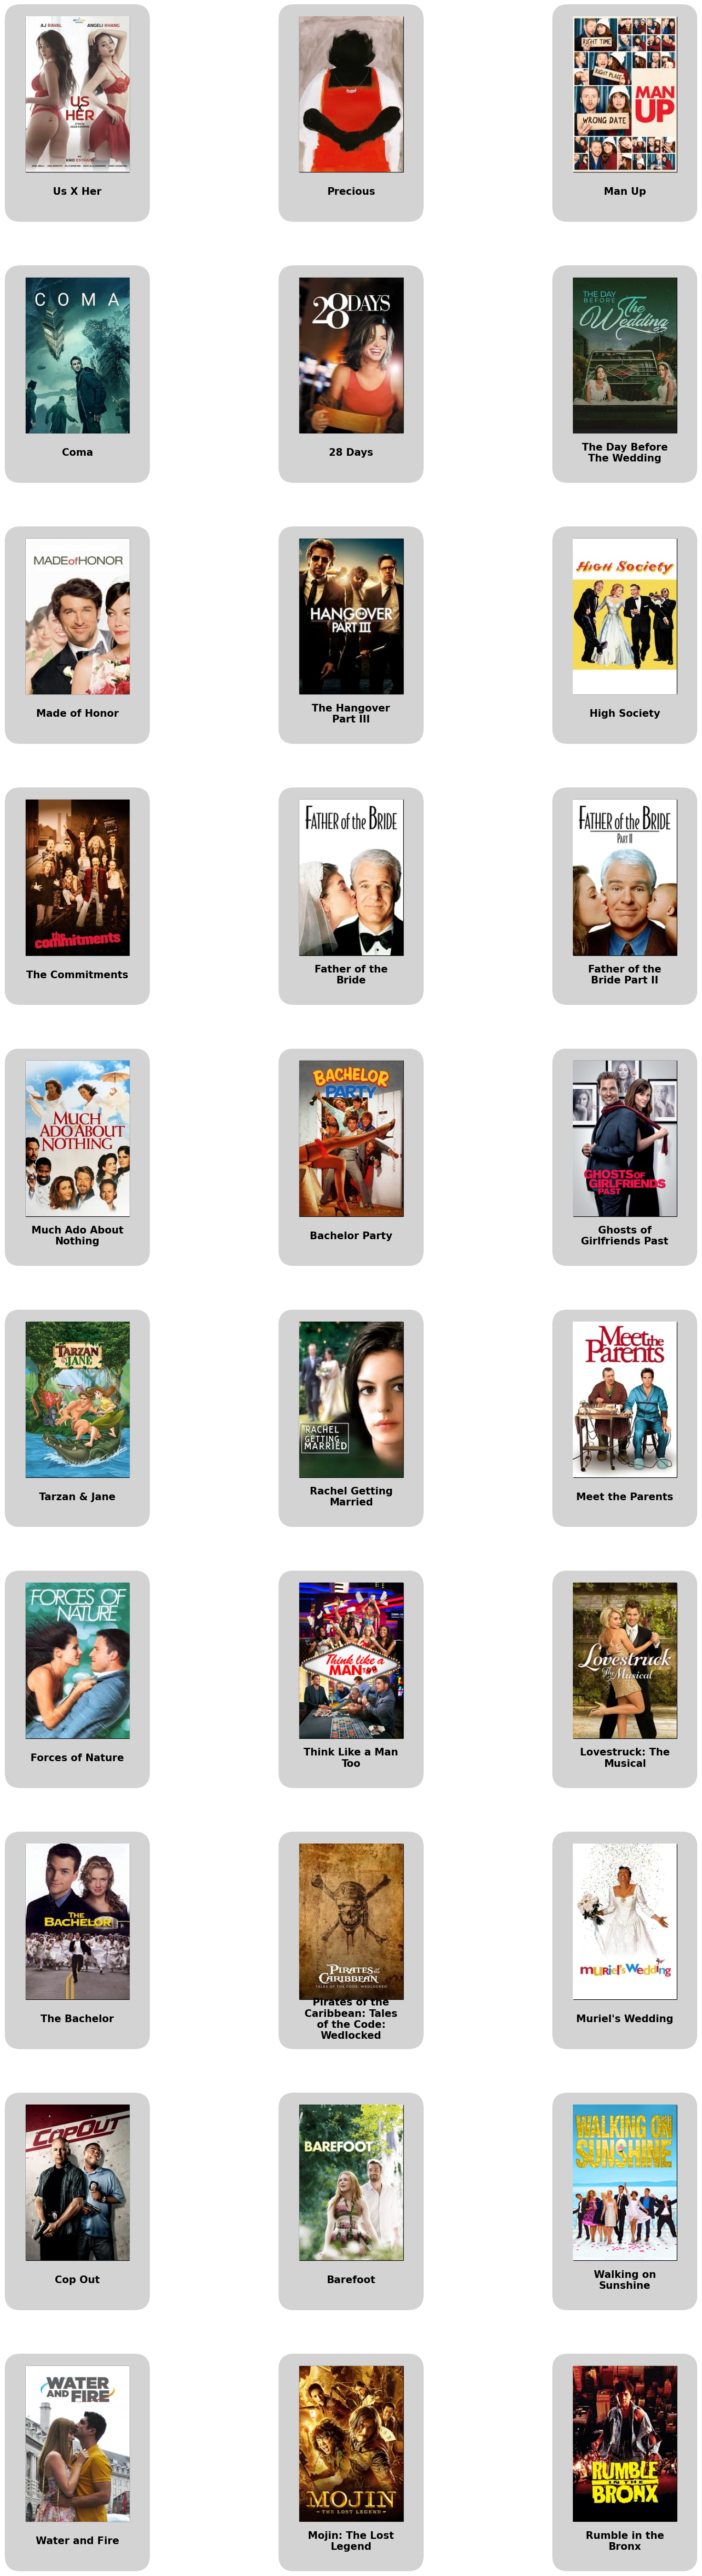

--------------------------------------------------------------
30 results in 28.21s


In [365]:
render_func = {'visual': show_visual, 'textual': show_textual}[render_choice]
head="""--------------------------------------------------------------
----------------------- FILMOWLEDGE CLI ----------------------
--------------------------------------------------------------
Please describe what kind of movies you are looking for today:
"""
textual_search = input(head)
print()
print("--------------------------------------------------------------")
print("We are identifying your interests...")
t0 = time()
ngrams = categorize_input(textual_search, n_groups=4)
r = sparql_request_valid_topics(g, ngrams)
#print (r)
print("Looking for interesting movies...")
qres = list(sparql_request_from_topics(g, r, limit=LIMIT))
print("Loading the results...")
render_func(qres)
t1 = time()
print("--------------------------------------------------------------")
print(f"{str(len(qres))} results in {str(round(t1-t0, 2))}s")